# 🎮 Steam RecSys: EDA & Data Preprocessing

- **Goal:** Prepare implicit feedback data (Playtime) for BPR/LightGCN models.
- **Method:** 
    1. Filter 'refund' gamers (<2h).
    2. Apply **Item-wise Quantile Scaling** to handle 'Game Length Bias'.

In [ ]:
# ====== 1. Environment & Imports ======
import os
import ast
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

# Settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
load_dotenv()

# Path
DATA_PATH = '../../steam/now_steam/australian_users_items.json'
print(f"Data Path: {DATA_PATH}")

Data Path: ../../steam/now_steam/australian_users_items.json


In [ ]:
games=open(DATA_PATH, 'r', encoding='utf-8')

print(print(games.readline()))

<_io.TextIOWrapper name='../../steam/now_steam/australian_users_items.json' mode='r' encoding='UTF-8'>

In [17]:
# ====== 2. Data Loading (Efficient) ======
def load_steam_data(filepath):
    rows = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                # Note: The file format is often python-dict string, not strict JSON
                data = ast.literal_eval(line.strip())
                u_id = data['user_id']
                for item in data['items']:
                    rows.append([u_id, item['item_id'], item['playtime_forever']])
            except (SyntaxError, ValueError):
                continue
    return pd.DataFrame(rows, columns=['user_id', 'item_id', 'playtime_forever'])

print("Loading Data... (This might take a while)")
df = load_steam_data(DATA_PATH)
print(f"Loaded Raw Data: {len(df):,} rows")
df.head()

Loading Data... (This might take a while)
Loaded Raw Data: 1,881,150 rows


,user_id,item_id,playtime_forever
0,76561197970982479,10,6
1,76561197970982479,20,0
2,76561197970982479,30,7
3,76561197970982479,40,0
4,76561197970982479,50,0


In [18]:
# ====== 3. Preprocessing: Filter 'True' Gamers ======

# Threshold: 2 hours (120 minutes) -> Refund Cutoff
df_clean = df[df['playtime_forever'] > 120].copy()

print(f"Before Filtering: {len(df):,} rows")
print(f"After Filtering (>2h): {len(df_clean):,} rows")
print(f"Removed (Refund/Trial): {len(df) - len(df_clean):,} rows ({1 - len(df_clean)/len(df):.1%})")

# Density Check
n_users = df_clean['user_id'].nunique()
n_items = df_clean['item_id'].nunique()
density = len(df_clean) / (n_users * n_items) * 100
print(f"Sparsity: {n_users:,} Users x {n_items:,} Items (Density: {density:.4f}%)")

Before Filtering: 1,881,150 rows
After Filtering (>2h): 737,790 rows
Removed (Refund/Trial): 1,143,360 rows (60.8%)
Sparsity: 16,044 Users x 7,394 Items (Density: 0.6219%)


In [19]:
# ====== 4. Feature Eng: Item-wise Quantile Scaling ======

def calculate_item_quantiles(df):
    print("Calculating Item-wise Quantiles...")
    
    # 1. Calculate Quantiles per Item
    # Quantiles: 0.3 (30%), 0.5 (50%), 0.7 (70%), 0.9 (90%)
    quantiles = df.groupby('item_id')['playtime_forever'].quantile([0.3, 0.5, 0.7, 0.9]).unstack()
    
    # 2. Merge with original data
    df_merged = df.merge(quantiles, left_on='item_id', right_index=True)
    
    # 3. Vectorized scoring
    conditions = [
        (df_merged['playtime_forever'] >= df_merged[0.9]),
        (df_merged['playtime_forever'] >= df_merged[0.7]),
        (df_merged['playtime_forever'] >= df_merged[0.5]),
        (df_merged['playtime_forever'] >= df_merged[0.3])
    ]
    
    # Scores: 10 (Veteran), 5 (Hardcore), 3 (Mid), 1 (Light)
    choices = [10, 5, 3, 1]
    
    df_merged['rating'] = np.select(conditions, choices, default=1)
    return df_merged[['user_id', 'item_id', 'playtime_forever', 'rating']]

final_df = calculate_item_quantiles(df_clean)
final_df.head()

Calculating Item-wise Quantiles...


,user_id,item_id,playtime_forever,rating
8,76561197970982479,300,4733,10
9,76561197970982479,240,1853,3
10,76561197970982479,3830,333,1
12,76561197970982479,3900,338,1
15,76561197970982479,6400,286,1


/tmp/ipykernel_732/212974788.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=final_df, ax=axes[1], palette='viridis')


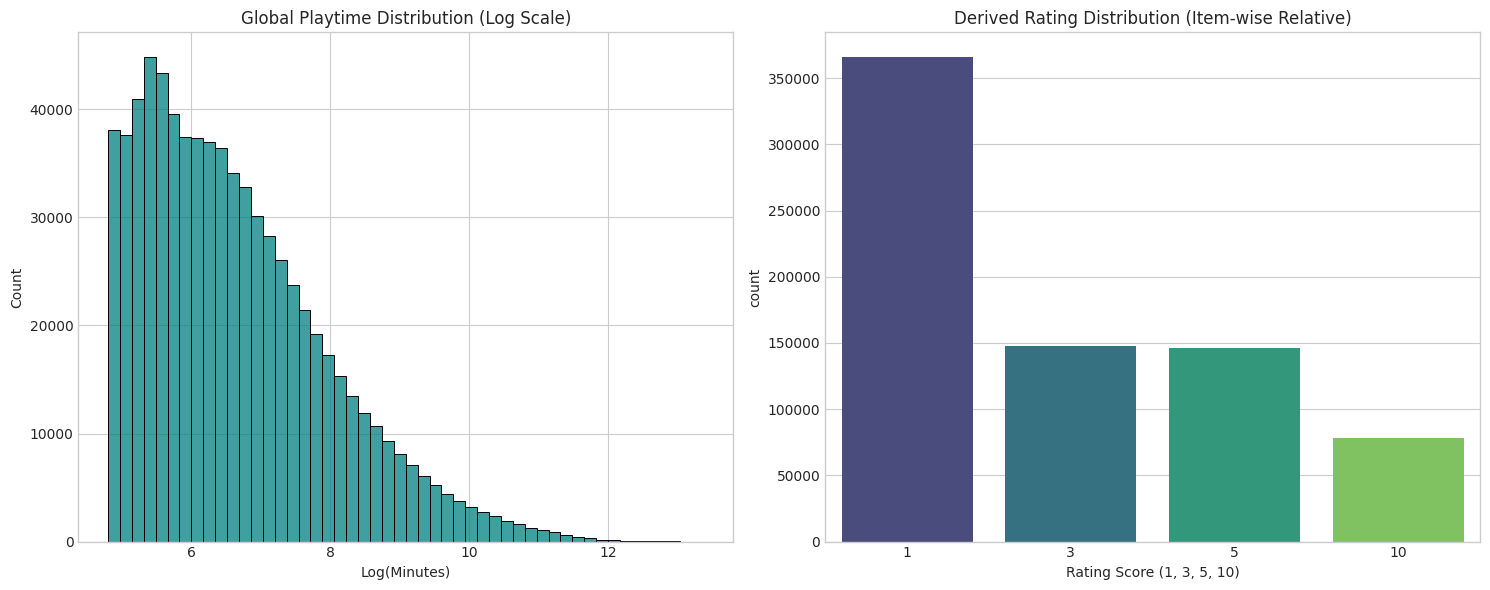

Rating Counts:
rating
1     366314
3     147580
5     145932
10     77964
Name: count, dtype: int64


In [20]:
# ====== 5. Visualization & Verification ======

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Log-Transformed Playtime Distribution (Global)
sns.histplot(np.log1p(df_clean['playtime_forever']), bins=50, ax=axes[0], color='teal')
axes[0].set_title("Global Playtime Distribution (Log Scale)")
axes[0].set_xlabel("Log(Minutes)")

# Plot 2: Rating Distribution (After Scaling)
sns.countplot(x='rating', data=final_df, ax=axes[1], palette='viridis')
axes[1].set_title("Derived Rating Distribution (Item-wise Relative)")
axes[1].set_xlabel("Rating Score (1, 3, 5, 10)")

plt.tight_layout()
plt.show()

# Stats
print("Rating Counts:")
print(final_df['rating'].value_counts().sort_index())

# 📊 Session 1. Logic & Preprocessing Report (요약 보고서)

## 1. Data Filtering Strategy
- **Noise Reduction:** 플레이타임 2시간 미만 유저 제거 (환불/찍먹 방지)
- **Target Audience:** '진성 유저' 데이터만 남겨 추천 품질 향상

## 2. Playtime Scaling Logic ('문명' vs '포탈' 문제 해결)
- **Issue:** 
    - 플레이타임(절대시간)을 그대로 쓰면, 호흡이 긴 게임(MMO/전략)이 짧은 명작(퍼즐/스토리)보다 무조건 높은 점수를 받음.
- **Solution:** **Item-wise Quantile Scaling (게임별 상대평가)**
- **Method:** 
    - 각 게임별로 유저들의 플레이타임 분위수(Top 10%, 30%...)를 구함.
    - 게임 내 상대적 위치에 따라 점수(Rating) 부여.

| Threshold (상위 %) | Rating | Meaning (Persona) |
| :--- | :--- | :--- |
| Top 10% (q0.9) | **10** | **Veteran / 고인물** (통달함) |
| Top 30% (q0.7) | **5** | **Hardcore** (깊게 파고듦) |
| Top 50% (q0.5) | **3** | **Mid-Core** (엔딩/기본 플레이 완료) |
| Bottom 50% | **1** | **Light** (가볍게 즐김) |

## 3. Next Steps
- **Genre Analysis:** 이 점수 체계가 장르별 특성(RPG vs 아케이드)과 잘 맞는지 `steam_games.json`으로 검증.
- **Modeling:** 생성된 Rating을 활용해 BPR(순위)/LightGCN(관계) 모델 학습.